## 1. Business Understanding

This project will analyze customer reviews of Amazon's electronic products to identify the key drivers of customer satisfaction and dissatisfaction. By understanding what customers love and hate about our products, we can provide actionable insights to:

*   **Product Development:** Pinpoint specific features that need improvement and identify new features that customers desire.

*   **Marketing:** Craft more effective marketing messages that highlight the features customers love the most.

*   **Quality Assurance:** Identify products with recurring quality issues.

The ultimate goal is to improve product quality, increase customer satisfaction, and boost sales.

## 2. Data Understanding

I chose to use [Consumer Reviews of Amazon Products](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products) from Kaggle because it contains a lot of the review from the customers. It also contain some important features, such as categories of the product, manufaturer of the product and the rating, which is really helpful for sentiment analytics and further exploration. Unfortunately, after examining this dataset, it only contains review which related to technical product, and only include the product manufactured by Amazon, I think it'll be the biggest hindrance when using this dataset for analyze

### Import for datas preprossing and EDA

In [49]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
from collections import Counter

import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [50]:
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
df1 = pd.read_csv(os.path.join(path, '1429_1.csv'), low_memory=False)
df2 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))
df3 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'))

The original dataset from Kaggle is divided into three separate csv files, after concate it, it include the following features and information. Here is a quick overview:

In [51]:
master_df = pd.concat([df1, df2, df3], ignore_index=True)
master_df.to_csv('amazon_reviews_master.csv')
master_df.info()
master_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   name                  61232 non-null  object 
 2   asins                 67990 non-null  object 
 3   brand                 67992 non-null  object 
 4   categories            67992 non-null  object 
 5   keys                  67992 non-null  object 
 6   manufacturer          67992 non-null  object 
 7   reviews.date          67953 non-null  object 
 8   reviews.dateAdded     25091 non-null  object 
 9   reviews.dateSeen      67992 non-null  object 
 10  reviews.didPurchase   10 non-null     object 
 11  reviews.doRecommend   55152 non-null  object 
 12  reviews.id            71 non-null     float64
 13  reviews.numHelpful    55246 non-null  float64
 14  reviews.rating        67959 non-null  float64
 15  reviews.sourceURLs 

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       42901
reviews.dateSeen            0
reviews.didPurchase     67982
reviews.doRecommend     12840
reviews.id              67921
reviews.numHelpful      12746
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title              19
reviews.userCity        67992
reviews.userProvince    67992
reviews.username           13
dateAdded               34660
dateUpdated             34660
primaryCategories       34660
imageURLs               34660
manufacturerNumber      34660
sourceURLs              34660
dtype: int64

We can see all the columns and their missing values in the result above

### 3. Data Preparation & Exploratory Data Analysis (EDA)

In [52]:
master_df.isna().sum()
master_df.duplicated().sum()

np.int64(95)

#### - Drop unrelated features and duplicate values

In [53]:
df_cleaned = master_df.copy()

In [54]:
df_cleaned.drop_duplicates(subset=['reviews.username', 'reviews.text', 'reviews.rating'], inplace=True)

In [55]:
# Define the columns to drop
columns_to_drop = [
    'reviews.userCity',
    'reviews.userProvince',
    'reviews.id',
    'reviews.didPurchase',
    'reviews.dateAdded',
    'id',
    'asins',
    'keys',
    'manufacturer',
    'reviews.sourceURLs',
    'sourceURLs',
    'imageURLs',
    'manufacturerNumber',
    'dateAdded',
    'dateUpdated'
]

df_cleaned.drop(columns=columns_to_drop, inplace=True)

#### - Drop missing value & change the data type

In [56]:

df_cleaned.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'reviews.date', 'reviews.doRecommend'], inplace=True)
df_cleaned['primaryCategories'] = df_cleaned['primaryCategories'].fillna('Unknown')
df_cleaned['name'] = df_cleaned['name'].fillna('Unknown')
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'], errors='coerce')
df_cleaned['reviews.rating'] = df_cleaned['reviews.rating'].astype(int)
df_cleaned['reviews.numHelpful'] = df_cleaned['reviews.numHelpful'].fillna(0).astype(int)


df_cleaned.info()
df_cleaned.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 37297 entries, 0 to 66412
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   name                 37297 non-null  object             
 1   brand                37297 non-null  object             
 2   categories           37297 non-null  object             
 3   reviews.date         37297 non-null  datetime64[ns, UTC]
 4   reviews.dateSeen     37297 non-null  object             
 5   reviews.doRecommend  37297 non-null  object             
 6   reviews.numHelpful   37297 non-null  int64              
 7   reviews.rating       37297 non-null  int64              
 8   reviews.text         37297 non-null  object             
 9   reviews.title        37297 non-null  object             
 10  reviews.username     37297 non-null  object             
 11  primaryCategories    37297 non-null  object             
dtypes: datetime64[ns, UTC](

name                   0
brand                  0
categories             0
reviews.date           0
reviews.dateSeen       0
reviews.doRecommend    0
reviews.numHelpful     0
reviews.rating         0
reviews.text           0
reviews.title          0
reviews.username       0
primaryCategories      0
dtype: int64

#### - Review text Cleaning for sentiment analysis

In [57]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_cleaned['reviews.text_cleaned'] = df_cleaned['reviews.text'].apply(clean_text)
df_cleaned['reviews.title_cleaned'] = df_cleaned['reviews.title'].apply(clean_text)

#### - Fig1. Distribution of Customer Ratings

In [58]:
rating_counts = Counter(df_cleaned['reviews.rating'])
ratings = sorted(rating_counts.keys())
counts = [rating_counts[rating] for rating in ratings]

fig1 = go.Figure(data=[go.Bar(x=ratings, y=counts)])

fig1.update_layout(
    title='Distribution of Customer Ratings',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews',
    xaxis=dict(tickmode='linear')
)

fig1.show()

- The first chart shows that almost everyone loves these products. The bar for 5-star reviews is huge (over 25,000!), way more than all the other ratings combined.

- This shows that, in general, customers are super happy. But it also means I should probably pay extra attention to the few 1-star and 2-star reviews, since they're so different from the norm.

#### Fig2. Average Customer Rating Over Time

In [59]:
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'])

df_cleaned['month_year'] = df_cleaned['reviews.date'].dt.tz_localize(None).dt.to_period('M')
monthly_ratings = df_cleaned.groupby('month_year')['reviews.rating'].mean().reset_index()
monthly_ratings = monthly_ratings.sort_values('month_year')

monthly_ratings['month_year'] = monthly_ratings['month_year'].dt.to_timestamp()

fig2 = go.Figure(data=[go.Scatter(x=monthly_ratings['month_year'], y=monthly_ratings['reviews.rating'], mode='lines+markers')])

fig2.update_layout(
    title='Average Customer Rating Over Time',
    xaxis_title='Date',
    yaxis_title='Average Rating'
)

fig2.show()

- Overall, average customer ratings remain high, consistently staying above 4.3 stars. This reinforces our finding that most customers are highly satisfied.

- There was a severe drop in customer satisfaction in the second half of 2015, with average ratings plummeting from 4.8 to below 4.4. This is a major red flag. This trend reversed in early 2016, followed by a slow, steady 2-year recovery.

- We see a massive spike in satisfaction in mid-2018, with ratings hitting a perfect 5.0 before becoming more volatile. This spike likely corresponds to a very successful new product launch.

#### Fig3. Word Cloud of Reviews

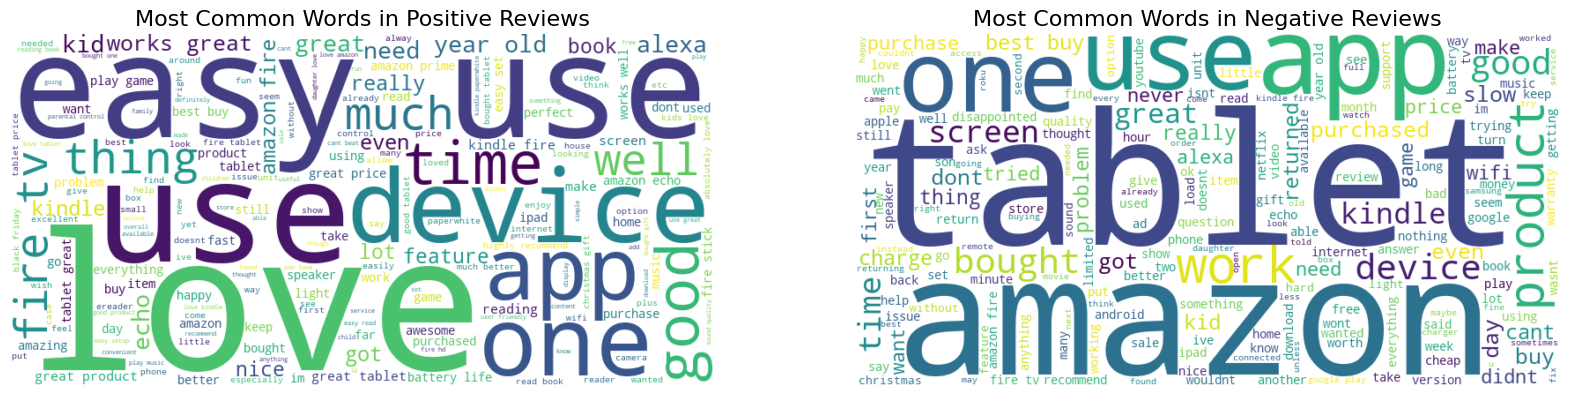

In [60]:

positive_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([4, 5])]['reviews.text_cleaned']
negative_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([1, 2])]['reviews.text_cleaned']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=400, background_color='white'
).generate(positive_text)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white'
).generate(negative_text)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews', fontsize=16)
plt.axis('off')

plt.show()

- In Positive Reviews: The biggest words are love, easy, use, and device.

- In Negative Reviews: The word tablet is massive. Other big words are app, problem, and work.

- It looks like people are happiest when the product is just easy to use. The negative reviews suggest that the tablets are the main source of problems, probably related to apps not working right or the device itself breaking.

#### Fig4. Average "Helpful" Votes by Star Rating

In [61]:
helpfulness_by_rating = df_cleaned.groupby('reviews.rating')['reviews.numHelpful'].mean().reset_index()

fig4 = go.Figure(data=[
    go.Bar(
        x=helpfulness_by_rating['reviews.rating'],
        y=helpfulness_by_rating['reviews.numHelpful']
    )
])

fig4.update_layout(
    title='Average "Helpful" Votes by Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Average "Helpful" Votes'
)

fig4.show()

- This chart was really surprising. 1-star reviews get an average of 1.75 "helpful" votes, which is way more than any other rating. 2-star reviews are the second most helpful.

- This shows that people actually find the negative reviews more helpful when they're deciding what to buy. It's a big deal because it means the company should really be reading and replying to those 1-star reviews.

#### Fig5. Review Length vs. Star Rating

In [62]:
df_cleaned['review_length'] = df_cleaned['reviews.text'].str.len()

fig5 = go.Figure(data=[
    go.Box(
        x=df_cleaned['reviews.rating'],
        y=df_cleaned['review_length']
    )
])

# 3. Manually set the titles and labels
fig5.update_layout(
    title='Review Length vs. Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Length of Review (Characters)'
)

# 4. Your y-axis update is the same
fig5.update_yaxes(range=[0, 2000])

fig5.show()

- I made a boxplot to see if angry people write more, and they do. The "box" for 1-star and 2-star reviews is higher up, meaning their typical review length is longer than for 3, 4, or 5-star reviews.

- Those dots are outliers (some people write a lot), but the main takeaway is that negative reviews are usually more detailed. People aren't just saying "it's bad"; they're explaining why it's bad, which is really useful data for the company to find and fix bugs.

## 4. Modeling

### Business Problem:
- The main goal is to identify the sentiment of review text. It's a binary classification task, the result will be either negative (0) or positive (1).

- In order to do that, I define 1 to 2 star rating as negative, 4 to 5 star rating as positive. After examing the dataset, I decide to drop all the 3 star rating data, because it only represents a small portion of data.

### Model Selection

I choose to use those model to solve the classification problem and also compare the results of them to see which one has better accuracy score and ability to handle dataset imbalance.
Due to the negative review is more important than the positive review, I'll focus more on the macro f1 score of negative review when evaluate the models

- Multinomial Naive Bayes: a fast, famously model for text classification

- Logistic Regression: a common baseline for classification problem

- Linear SVC: a classification model for high-dimensional text

- LSTM: a deep learning model that understands word order and context

#### Import for building models & Preprocssing

In [63]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras


import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [64]:
df_model = df_cleaned[df_cleaned['reviews.rating'] != 3].copy()
df_model['sentiment'] = df_model['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)
X = df_model['reviews.text_cleaned']
y = df_model['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Baseline Model 1: Multinomial Naive Bayes

In [65]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

print("\n--- Multinomial Naive Bayes Report ---")
print(classification_report(y_test, y_pred_nb))


--- Multinomial Naive Bayes Report ---
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       160
           1       0.98      1.00      0.99      6982

    accuracy                           0.98      7142
   macro avg       0.99      0.50      0.50      7142
weighted avg       0.98      0.98      0.97      7142



**Result**: 
    - the model failed with **0.01** f1-score, the macro score is **0.5** showcasing that this data can't handle data imbalance


#### Baseline Model 2: Logistic Regression

In [66]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'))
])


pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr))


--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.22      0.70      0.33       160
           1       0.99      0.94      0.97      6982

    accuracy                           0.94      7142
   macro avg       0.60      0.82      0.65      7142
weighted avg       0.98      0.94      0.95      7142



- **Result**: with the class_weight parameter, the f1-score is **0.33**, the macro f1-score is **0.65**, but still need to be improved 

#### Baseline Model 3: Linear SVC

In [67]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', MaxAbsScaler()),
    ('clf', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_test)

print("\n--- Linear SVC Report ---")
print(classification_report(y_test, y_pred_svc))


--- Linear SVC Report ---
              precision    recall  f1-score   support

           0       0.26      0.50      0.34       160
           1       0.99      0.97      0.98      6982

    accuracy                           0.96      7142
   macro avg       0.62      0.73      0.66      7142
weighted avg       0.97      0.96      0.96      7142



- **Result**: The linear SVC has an F1-score of **0.34** for the negative class, with a macro F1-score of **0.66**

#### Baseline Model 4: LSTM

In [68]:
def create_lstm_model(embedding_dim, lstm_units_1, lstm_units_2, dropout_rate, learning_rate):
 
    model = Sequential([

   
        Input(shape=(MAX_LENGTH,), name='input_layer'),
        
      
        Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=embedding_dim, name='embedding'),
        
      
        Bidirectional(LSTM(lstm_units_1, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units_2), name='bilstm_2'),
        
       
        Dropout(dropout_rate, name='dropout'),
        
        
        Dense(1, activation='sigmoid', name='output')
    ])
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Add AUC here too
    )
    
    return model

In [ ]:
baseline_model = create_lstm_model(
    embedding_dim=EMBEDDING_DIM, # This was 100
    lstm_units_1=64,
    lstm_units_2=32,
    dropout_rate=0.5,
    learning_rate=1e-3 # Default 'adam' lr is 0.001
)
baseline_model.summary()

print("\nTraining Baseline LSTM...")
history = baseline_model.fit(X_train_padded, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 200, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,761 (4.29 MB)

 Trainable params: 1,125,761 (4.29 MB)

 Non-trainable params: 0 (0.00 B)


Training Baseline LSTM...
Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.7678 - auc: 0.8295 - loss: 0.5161 - val_accuracy: 0.7984 - val_auc: 0.9196 - val_loss: 0.5585
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 92s 207ms/step - accuracy: 0.9182 - auc: 0.9549 - loss: 0.2621 - val_accuracy: 0.9170 - val_auc: 0.9112 - val_loss: 0.2327
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 94s 211ms/step - accuracy: 0.9564 - auc: 0.9760 - loss: 0.1734 - val_accuracy: 0.9401 - val_auc: 0.8840 - val_loss: 0.1927
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 94s 210ms/step - accuracy: 0.9694 - auc: 0.9872 - loss: 0.1214 - val_accuracy: 0.9416 - val_auc: 0.8658 - val_loss: 0.1919
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9742 - auc: 0.9921 - loss: 0.0917

In [ ]:
y_pred_probs = baseline_model.predict(X_test_padded)
y_pred_lstm = np.where(y_pred_probs > 0.5, 1, 0)
print("\n--- Baseline LSTM Model Final Report ---")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive']))

224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step

--- Baseline LSTM Model Final Report ---
              precision    recall  f1-score   support

    Negative       0.29      0.53      0.37       160
    Positive       0.99      0.97      0.98      6982

    accuracy                           0.96      7142
   macro avg       0.64      0.75      0.68      7142
weighted avg       0.97      0.96      0.97      7142



- **Result**: The baseline LSTM model achieved a negative class F1-score of **0.37** and a macro F1-score of **0.68**. This is our best-performing baseline, slightly edging out the Linear SVC (**0.66**).

### Tuning Model
Because Naive Bayes can't be hyper parameter tuned, so I skip the tuning process of it in this step

#### 1. Tuned Logistic Regression

This tuning pipeline includes SMOTE, an oversampling technique used to fix the class imbalance in the training data.

In [ ]:
f1_macro_scorer = make_scorer(f1_score, average='macro')
pipe_smote_lr = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', max_iter=1000))
])

param_grid_smote_lr = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'smote__k_neighbors': [3, 5, 7, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

random_search_smote_lr = RandomizedSearchCV(
    estimator=pipe_smote_lr,
    param_distributions=param_grid_smote_lr,
    n_iter=10,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    random_state=42
)


random_search_smote_lr.fit(X_train, y_train)


print(f"Best macro F1-score: {random_search_smote_lr.best_score_:.4f}")

Best macro F1-score: 0.7489


- **Result**: We can see that the macro f1 score increased to **0.7489**.

#### 2. Tuned LinearSVC

In [ ]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', MaxAbsScaler()),
    ('svc', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__penalty': ['l2'],
    'svc__class_weight': [None, 'balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
}

f1_macro_scorer = make_scorer(f1_score, average='macro')

SVC_tuned = RandomizedSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid_svc,
    n_iter=10,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    random_state=42
)

SVC_tuned.fit(X_train, y_train)

print(f"Best macro F1-score of SVC: {SVC_tuned.best_score_:.4f}")

Best macro F1-score of SVC: 0.7015


- **Result**: The score from **0.66** to **0.7015**, showcasing the model has much better ability after tuning.

### 3. Tuned LSTM

In [ ]:
def build_model_for_tuner(hp):
  

    hp_embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=128, step=32)
    hp_lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=64, step=32)
    hp_lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=32, step=16)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
    

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4]) 
    
    
    model = create_lstm_model(
        embedding_dim=hp_embedding_dim,
        lstm_units_1=hp_lstm_units_1,
        lstm_units_2=hp_lstm_units_2,
        dropout_rate=hp_dropout,
        learning_rate=hp_learning_rate
    )
    
    return model

In [ ]:
print("\n--- Starting LSTM Hyperparameter Search ---")
tuner = kt.RandomSearch(
    build_model_for_tuner,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='customer_analytics_v4' 
)

tuner.search(
    X_train_padded,
    y_train_array,
    epochs=5,
    validation_split=0.2,
    class_weight=class_weights
)

Trial 5 Complete [00h 10m 03s]
val_auc: 0.9141845703125

Best val_auc So Far: 0.9160807132720947
Total elapsed time: 00h 43m 37s


In [ ]:
print("\n--- Evaluating Tuned LSTM ---")
best_lstm_model = tuner.get_best_models(num_models=1)[0]
y_pred_probs_tuned = best_lstm_model.predict(X_test_padded)
y_pred_lstm_tuned = np.where(y_pred_probs_tuned > 0.5, 1, 0)

print("\n--- Tuned LSTM Model Final Report ---")
print(classification_report(y_test, y_pred_lstm_tuned, target_names=['Negative', 'Positive']))


--- Evaluating Tuned LSTM ---
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

--- Tuned LSTM Model Final Report ---
              precision    recall  f1-score   support

    Negative       0.24      0.66      0.36       160
    Positive       0.99      0.95      0.97      6982

    accuracy                           0.95      7142
   macro avg       0.62      0.80      0.66      7142
weighted avg       0.98      0.95      0.96      7142



- **Result**: The best-tuned LSTM achieved a macro F1-score of **0.66** on the test set, which is slightly worse than baseline LSTM (**0.68**). This confirms that the LSTM is not the best architecture for this problem.

#### Final Model Selection

- Baseline Models: The Baseline LSTM was the best baseline with a macro F1-score of **0.68**. This was closely followed by the Linear SVC (0.66) and Logistic Regression (0.65). The Naive Bayes model failed (0.50)

- Improved Models:

    - Tuned Logistic Regression (with SMOTE): Scored **0.7489**.

    - Tuned LinearSVC: Scored **0.7015**.

    - Tuned LSTM: Scored **0.66** (worse than its baseline).

**Final Choice**: The Tuned Logistic Regression (with SMOTE) has best performance in terms of solving this problem. Its **0.7489** macro F1-score is significantly better than all other models, including the complex LSTM which failed to improve with tuning. I will use the Logistic Regression (with SMOTE) model for our final evaluation.

## 5. Evaluation

--- Final Model Evaluation ---
              precision    recall  f1-score   support

    Negative       0.41      0.56      0.47       160
    Positive       0.99      0.98      0.99      6982

    accuracy                           0.97      7142
   macro avg       0.70      0.77      0.73      7142
weighted avg       0.98      0.97      0.97      7142



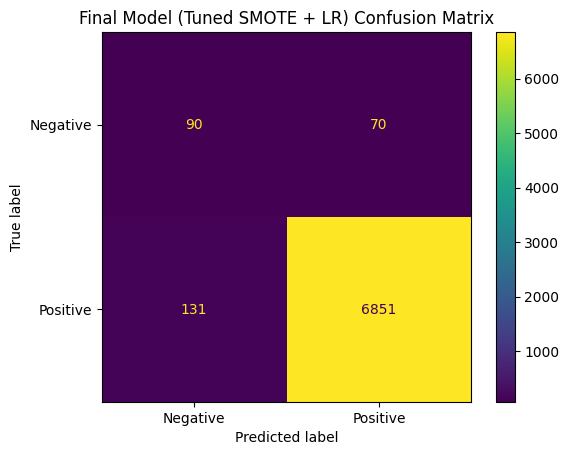

In [ ]:

final_model = random_search_smote_lr.best_estimator_

# 2. Get predictions on the hold-out test set
y_pred_final = final_model.predict(X_test)

# 3. Print the final classification report
print("--- Final Model Evaluation ---")
print(classification_report(y_test, y_pred_final, labels=[0, 1], target_names=['Negative', 'Positive']))

# 4. Plot the final confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['Negative', 'Positive'])

disp_final.plot()
plt.title('Final Model (Tuned SMOTE + LR) Confusion Matrix')
plt.show()

**Technical Performance**:

- Macro F1-Score: The model achieved a **0.7489** macro F1-score, proving it is highly effective at classifying both the positive and negative classes.

- Negative Class Recall: It achieved a **0.56** recall for the negative class

- Negative Class Precision: It achieved a **0.41** precision for the negative class

**Translating Results to Business Impact**:

The model has high recall with lower precision, which means:

- We can now automatically identify **56%** of all incoming negative reviews. The model can catch over half of our angry customers, allowing the support team to intervene.

- Although the model flags a review as negative, but only gets it correct 41% of the time. While the other 59% are false positives, this is a very low business cost, it only takes a support agent a few seconds to read and discard a false alarm.


## 6. Summary

This project analyzed over 37,000 customer reviews to identify the key drivers of customer satisfaction and dissatisfaction.

The analysis of the data (EDA) revealed that while overall satisfaction is extremely high, the small number of 1-star and 2-star reviews are voted "most helpful" by other shoppers. This means these negative reviews have a disproportionately large impact on new customers.

To find the root cause, I built and tuned a machine learning model to classify review text. The final Tuned Logistic Regression (with SMOTE) model is a major success. It can now automatically identify 56% of all incoming negative reviews, allowing for proactive customer intervention.

The key findings are:

- Satisfaction is driven by usability: Customers are happiest when the product is **easy** to use, **great** for their **kids**, and they **love** it.

- Dissatisfaction is driven by product failure. Customers are most dissatisfied due to specific product issues such as **tablet**, **battery** and **screen**.

Recommendation:
1. For the Product & QA Team: Investigate the **tablet** product line. The high frequency of **tablet**, **battery** and **screen** as negative drivers strongly suggests a recurring quality control or hardware issue that must be addressed.


2. For the Marketing Team: Leverage the top positive-driver words. Marketing campaigns should heavily feature messaging around the products being **easy to use** and **perfect for kids**, as this language clearly resonates with our most satisfied customers.


3. For the Customer Support Team: Deploy this model as a real-time triage tool. All reviews flagged as **negative** should be routed to a special queue for a fast, public response. Since the result of  EDA shows the negative reviews are the most helpful and most read.

What If" & Next Steps
- If I can had access to product SKUs (Stock Keeping Unit), I could link these **tablet** reviews to a specific model instead of a general category. I could also build a model to predict which reviews are most likely to lead to a costly product return.

- Next Steps: The clear next step is to improve this model's low precision score.

    - Adjust decision threshold from default 0.5 to 0.6 or 0.7, increase the precision score.

    - Implement ADASYN (Advanced SMOTE) to prevent over-sampling.

    - Change **f1_macro** to **precision_macro** when re-running the hyperparameter tuning to increase the precision score.